In [24]:
# import packages
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA,TruncatedSVD

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, LSTM, Embedding, SpatialDropout1D, Lambda, Reshape
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow_hub as hub

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss

import time

import gc

from numba import cuda

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold
from matplotlib import pyplot

In [25]:
#num_sample = 5000
#num_sample = 50000
num_sample = 100000

In [26]:
df = pd.read_csv('/kaggle/input/686-project/df_new.csv').sample(num_sample,random_state = 1234)
decode_map = {"negative":0, "positive":1}
df.target = df.target.apply(lambda x: decode_map[x])
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(df['text'].astype(str), df['target'],test_size=0.20,
                                                           random_state=1234,
                                                           stratify = df['target'])

In [27]:
%%time
# consider both unigrams and bigrams in vectorizer
#tokenizer = TfidfVectorizer(min_df = 0.0001, ngram_range = (1,2))
tokenizer = TfidfVectorizer(min_df = 0.001, ngram_range = (1,2))
tokenizer.fit(X_train)
X_train = tokenizer.transform(X_train)
X_test = tokenizer.transform(X_test)
X_train.shape

CPU times: user 2.98 s, sys: 3.93 ms, total: 2.98 s
Wall time: 2.98 s


(80000, 1071)

In [28]:
params = {'n_estimators': [i * 100 for i in range(1,21)]}

In [29]:
xgb = XGBClassifier(tree_method='gpu_hist', n_estimators = 2000, seed = 1234)
evalset = [(X_train, y_train), (X_test,y_test)]
xgb.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)
results = xgb.evals_result()

[0]	validation_0-logloss:0.67389	validation_1-logloss:0.67419


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[1]	validation_0-logloss:0.66206	validation_1-logloss:0.66271
[2]	validation_0-logloss:0.65280	validation_1-logloss:0.65375
[3]	validation_0-logloss:0.64541	validation_1-logloss:0.64715
[4]	validation_0-logloss:0.63898	validation_1-logloss:0.64106
[5]	validation_0-logloss:0.63374	validation_1-logloss:0.63613
[6]	validation_0-logloss:0.62896	validation_1-logloss:0.63148
[7]	validation_0-logloss:0.62434	validation_1-logloss:0.62714
[8]	validation_0-logloss:0.62056	validation_1-logloss:0.62380
[9]	validation_0-logloss:0.61682	validation_1-logloss:0.62029
[10]	validation_0-logloss:0.61353	validation_1-logloss:0.61788
[11]	validation_0-logloss:0.61054	validation_1-logloss:0.61522
[12]	validation_0-logloss:0.60774	validation_1-logloss:0.61278
[13]	validation_0-logloss:0.60463	validation_1-logloss:0.61020
[14]	validation_0-logloss:0.60195	validation_1-logloss:0.60806
[15]	validation_0-logloss:0.59947	validation_1-logloss:0.60622
[16]	validation_0-logloss:0.59690	validation_1-logloss:0.60394
[

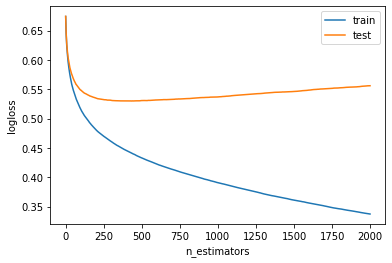

In [30]:
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
pyplot.xlabel("n_estimators")
pyplot.ylabel("logloss")
pyplot.legend()
pyplot.savefig('n_estimators_logloss.png')
pyplot.show()

In [31]:
xgb = XGBClassifier(tree_method='gpu_hist', n_estimators = 2000,seed = 1234)
evalset = [(X_train, y_train), (X_test,y_test)]
xgb.fit(X_train, y_train, eval_metric='error', eval_set=evalset)
results = xgb.evals_result()

[0]	validation_0-error:0.43709	validation_1-error:0.43710
[1]	validation_0-error:0.41892	validation_1-error:0.42070
[2]	validation_0-error:0.39165	validation_1-error:0.39265
[3]	validation_0-error:0.37466	validation_1-error:0.37715
[4]	validation_0-error:0.36539	validation_1-error:0.36805
[5]	validation_0-error:0.35725	validation_1-error:0.36000
[6]	validation_0-error:0.35374	validation_1-error:0.35525
[7]	validation_0-error:0.34936	validation_1-error:0.35045
[8]	validation_0-error:0.34850	validation_1-error:0.34965
[9]	validation_0-error:0.34296	validation_1-error:0.34490
[10]	validation_0-error:0.34041	validation_1-error:0.34310
[11]	validation_0-error:0.33576	validation_1-error:0.33835
[12]	validation_0-error:0.33270	validation_1-error:0.33565
[13]	validation_0-error:0.32726	validation_1-error:0.33115
[14]	validation_0-error:0.32265	validation_1-error:0.32800
[15]	validation_0-error:0.31872	validation_1-error:0.32550
[16]	validation_0-error:0.31624	validation_1-error:0.32325
[17]	va

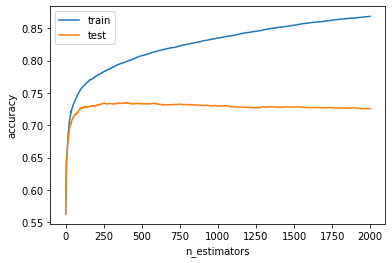

In [32]:
pyplot.plot(np.ones(2000)-results['validation_0']['error'], label='train')
pyplot.plot(np.ones(2000)-results['validation_1']['error'], label='test')
pyplot.xlabel("n_estimators")
pyplot.ylabel("accuracy")
pyplot.legend()
pyplot.savefig('n_estimators_accuracy.png')
pyplot.show()

The long flat curves may suggest that the algorithm is learning too fast and we may benefit from slowing it down.

In [33]:
test_error = results['validation_1']['error']
test_error.index(min(test_error))

388

# So we choose n_estimator = 388 for minimum testing error

From the logloss, the learning speed is fast. Let us slow it down

In [34]:
accuracy = []
etas = [i*0.01 for i in range(1,31)] # 0.01 to 0.3
for i in etas:
    xgb = XGBClassifier(tree_method='gpu_hist', n_estimators = 388, eta = i,seed = 1234)
    xgb.fit(X_train, y_train)
    predictions = xgb.predict(X_test)
    accuracy.append(accuracy_score(y_test,predictions))

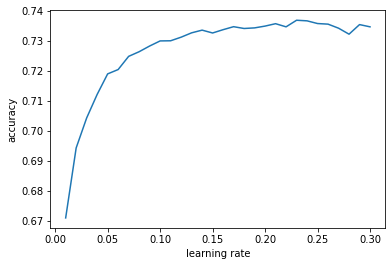

In [35]:
pyplot.plot(etas,accuracy)
pyplot.xlabel("learning rate")
pyplot.ylabel("accuracy")
pyplot.savefig('learning_rate_accuracy.png')
pyplot.show()

In [36]:
best_lr = accuracy.index(max(accuracy))*0.01
best_lr

0.22

# choose learning rate = 0.22

In [37]:
xgb = XGBClassifier(tree_method='gpu_hist', n_estimators = 388, eta = best_lr,seed = 1234)
evalset = [(X_train, y_train), (X_test,y_test)]
xgb.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)
results = xgb.evals_result()

[0]	validation_0-logloss:0.67838	validation_1-logloss:0.67859
[1]	validation_0-logloss:0.66833	validation_1-logloss:0.66884
[2]	validation_0-logloss:0.66044	validation_1-logloss:0.66096
[3]	validation_0-logloss:0.65386	validation_1-logloss:0.65494
[4]	validation_0-logloss:0.64825	validation_1-logloss:0.64979
[5]	validation_0-logloss:0.64353	validation_1-logloss:0.64504


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[6]	validation_0-logloss:0.63945	validation_1-logloss:0.64119
[7]	validation_0-logloss:0.63548	validation_1-logloss:0.63780
[8]	validation_0-logloss:0.63187	validation_1-logloss:0.63438
[9]	validation_0-logloss:0.62826	validation_1-logloss:0.63091
[10]	validation_0-logloss:0.62516	validation_1-logloss:0.62835
[11]	validation_0-logloss:0.62245	validation_1-logloss:0.62586
[12]	validation_0-logloss:0.61992	validation_1-logloss:0.62356
[13]	validation_0-logloss:0.61729	validation_1-logloss:0.62147
[14]	validation_0-logloss:0.61496	validation_1-logloss:0.61936
[15]	validation_0-logloss:0.61264	validation_1-logloss:0.61737
[16]	validation_0-logloss:0.61027	validation_1-logloss:0.61503
[17]	validation_0-logloss:0.60824	validation_1-logloss:0.61318
[18]	validation_0-logloss:0.60642	validation_1-logloss:0.61164
[19]	validation_0-logloss:0.60448	validation_1-logloss:0.60998
[20]	validation_0-logloss:0.60241	validation_1-logloss:0.60806
[21]	validation_0-logloss:0.60055	validation_1-logloss:0.60

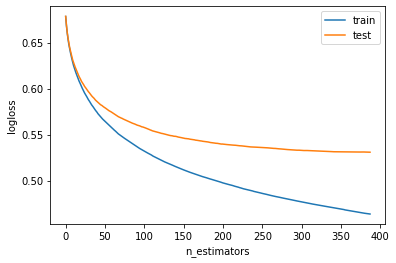

In [38]:
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
pyplot.xlabel("n_estimators")
pyplot.ylabel("logloss")
pyplot.legend()
pyplot.savefig('check_logloss_after_learningrate.png')
pyplot.show()

In [39]:
accuracy = []
subsamples = [0.01,0.05]+[0.1+i*0.05 for i in range(0,9)] # 0.01 to 0.5
for i in subsamples:
    xgb = XGBClassifier(tree_method='gpu_hist', n_estimators = 388, eta = best_lr,subsample = i,seed = 1234)
    xgb.fit(X_train, y_train)
    predictions = xgb.predict(X_test)
    accuracy.append(accuracy_score(y_test,predictions))

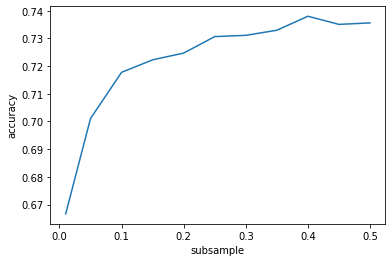

In [40]:
pyplot.plot(subsamples,accuracy)
pyplot.xlabel("subsample")
pyplot.ylabel("accuracy")
pyplot.savefig('choose_subsample.png')
pyplot.show()

In [41]:
best_subsample = subsamples[accuracy.index(max(accuracy))]
best_subsample

0.4

# choose subsample = 0.4

In [42]:
accuracy = []
colsample_bytree = [0.01,0.05]+[0.1+i*0.05 for i in range(0,9)] # 0.01 to 0.5
for i in colsample_bytree:
    xgb = XGBClassifier(tree_method='gpu_hist', n_estimators = 388, eta = best_lr,subsample = best_subsample, colsample_bytree = i,seed = 1234)
    xgb.fit(X_train, y_train)
    predictions = xgb.predict(X_test)
    accuracy.append(accuracy_score(y_test,predictions))

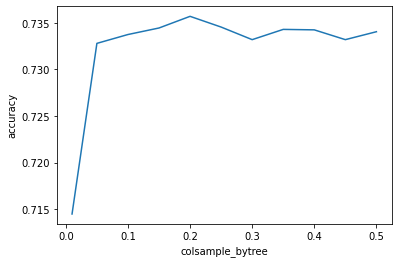

In [43]:
pyplot.plot(colsample_bytree,accuracy)
pyplot.xlabel("colsample_bytree")
pyplot.ylabel("accuracy")
pyplot.savefig('choose_colsample_bytree.png')
pyplot.show()

In [44]:
best_colsample_bytree = colsample_bytree[accuracy.index(max(accuracy))]
best_colsample_bytree

0.2

# choose colsample_bytree = 0.2

Finally: XGBClassifier(tree_method='gpu_hist', n_estimators = 388, eta = 0.22,subsample = 0.4, colsample_bytree = 0.2)